In [ ]:
!pip install imblearn

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline as SkPipeline
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report,
    roc_auc_score, balanced_accuracy_score,
)

try:
    from imblearn.over_sampling import RandomOverSampler
    from imblearn.pipeline import Pipeline as ImbPipeline
    IMB_INSTALLED = True
except ImportError:
    RandomOverSampler = None
    ImbPipeline = None
    IMB_INSTALLED = False

RANDOM_STATE = 42
USE_OVERSAMPLING = True  # enable RandomOverSampler if imblearn is available


# 2 next lines only for google collab
from google.colab import drive
drive.mount('/content/gdrive')
from pathlib import Path


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 10.9 MB/s eta 0:00:00
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:

# Load tab-delimited file (Kaggle dataset)
DATA_PATH = Path("gdrive/My Drive/WeatherFlightDelay/flights_prepared.csv")
df = pd.read_csv(DATA_PATH, engine="python")

# df = pd.read_csv("flights_prepared.csv")
print("Loaded CSV with shape:", df.shape)
TARGET = "delay_15"
DATE_COL = "FL_DATE"

Loaded CSV with shape: (500000, 29)


In [ ]:
df = df.sort_values(by=DATE_COL)

train_df, temp_df = train_test_split(df, test_size=0.30, shuffle=False)
val_df, test_df = train_test_split(temp_df, test_size=0.50, shuffle=False)

print("Split sizes -> train:", len(train_df), "val:", len(val_df), "test:", len(test_df))

X_train = train_df.drop(columns=[TARGET])
y_train = train_df[TARGET]

X_val = val_df.drop(columns=[TARGET])
y_val = val_df[TARGET]

X_test = test_df.drop(columns=[TARGET])
y_test = test_df[TARGET]

Split sizes -> train: 350000 val: 75000 test: 75000


In [ ]:
numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        (
            "num",
            SkPipeline(
                [
                    ("imputer", SimpleImputer(strategy="median")),
                    ("scaler", StandardScaler()),
                ]
            ),
            numeric_features,
        ),
        (
            "cat",
            SkPipeline(
                [
                    ("imputer", SimpleImputer(strategy="most_frequent")),
                    ("onehot", OneHotEncoder(handle_unknown="ignore")),
                ]
            ),
            categorical_features,
        ),
    ]
)

print("Preprocessing steps defined for numeric and categorical features.")

Preprocessing steps defined for numeric and categorical features.


In [ ]:
all_metrics = []
def train_and_eval(model, model_name):
    steps = [("preprocessor", preprocessor)]
    pipeline_cls = SkPipeline
    if USE_OVERSAMPLING and IMB_INSTALLED:
        steps.append(("oversample", RandomOverSampler(random_state=RANDOM_STATE)))
        pipeline_cls = ImbPipeline
    elif USE_OVERSAMPLING and not IMB_INSTALLED:
        print(f"imblearn not installed; running {model_name} without oversampling.")

    steps.append(("model", model))
    pipe = pipeline_cls(steps=steps)

    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_val)

    try:
        proba = pipe.predict_proba(X_val)[:, 1]
    except AttributeError:
        proba = None

    acc = accuracy_score(y_val, preds)
    prec = precision_score(y_val, preds, zero_division=0)
    rec = recall_score(y_val, preds, zero_division=0)
    f1 = f1_score(y_val, preds, zero_division=0)
    bal_acc = balanced_accuracy_score(y_val, preds)

    cm = confusion_matrix(y_val, preds)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else np.nan

    if proba is not None:
        roc_auc = roc_auc_score(y_val, proba)
    else:
        roc_auc = np.nan

    print(f"\n===== {model_name} === পল্ল  ")
    print("Accuracy           :", acc)
    print("Balanced Accuracy  :", bal_acc)
    print("Precision (positive class=1):", prec)
    print("Recall (Sensitivity):", rec)
    print("Specificity        :", specificity)
    print("F1 Score           :", f1)
    print("ROC-AUC            :", roc_auc)
    print("Confusion Matrix:\n", cm)
    print("\nClassification report:\n",
          classification_report(y_val, preds, digits=3))

    # store metrics for summary
    all_metrics.append({
        "model": model_name,
        "accuracy": acc,
        "balanced_accuracy": bal_acc,
        "precision": prec,
        "recall": rec,
        "specificity": specificity,
        "f1": f1,
        "roc_auc": roc_auc,
        "tn": tn,
        "fp": fp,
        "fn": fn,
        "tp": tp,
    })

    return pipe, cm

print("The 'train_and_eval' function has been defined.")

The 'train_and_eval' function has been defined.


In [ ]:
def plot_cm(cm, title):
    plt.imshow(cm, cmap="Blues")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], ha="center", va="center", color="black")

    plt.tight_layout()
    plt.show()

print("The 'plot_cm' function has been defined.")

The 'plot_cm' function has been defined.



===== Logistic Regression (SMOTE) === 
Accuracy           : 0.85608
Balanced Accuracy  : 0.5453160582409209
Precision (positive class=1): 0.35597667638483965
Recall (Sensitivity): 0.12451560269222925
Specificity        : 0.9661165137896125
F1 Score           : 0.18449682683590207
ROC-AUC            : 0.6661256820517881
Confusion Matrix:
 [[62985  2209]
 [ 8585  1221]]

Classification report:
               precision    recall  f1-score   support

           0      0.880     0.966     0.921     65194
           1      0.356     0.125     0.184      9806

    accuracy                          0.856     75000
   macro avg      0.618     0.545     0.553     75000
weighted avg      0.812     0.856     0.825     75000



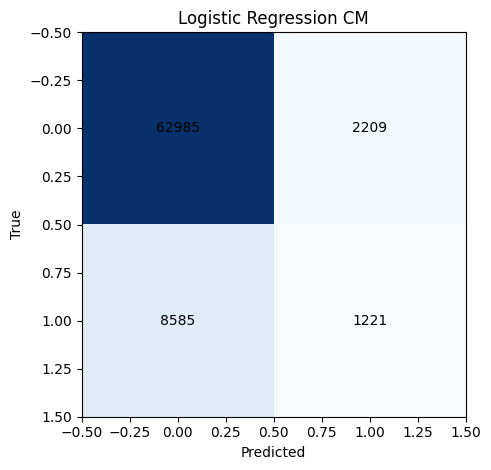

In [ ]:
lr_model, lr_cm = train_and_eval(
    LogisticRegression(max_iter=1000,
                      #  class_weight="balanced",
                       random_state=RANDOM_STATE),
    "Logistic Regression"
)
plot_cm(lr_cm, "Logistic Regression CM")


imblearn not installed; running Decision Tree without oversampling.

===== Decision Tree === পল্ল  
Accuracy           : 0.81384
Balanced Accuracy  : 0.5442387420726333
Precision (positive class=1): 0.2290743155149935
Recall (Sensitivity): 0.1791760146848868
Specificity        : 0.9093014694603798
F1 Score           : 0.2010757610437171
ROC-AUC            : 0.6047418759721022
Confusion Matrix:
 [[59281  5913]
 [ 8049  1757]]

Classification report:
               precision    recall  f1-score   support

           0      0.880     0.909     0.895     65194
           1      0.229     0.179     0.201      9806

    accuracy                          0.814     75000
   macro avg      0.555     0.544     0.548     75000
weighted avg      0.795     0.814     0.804     75000



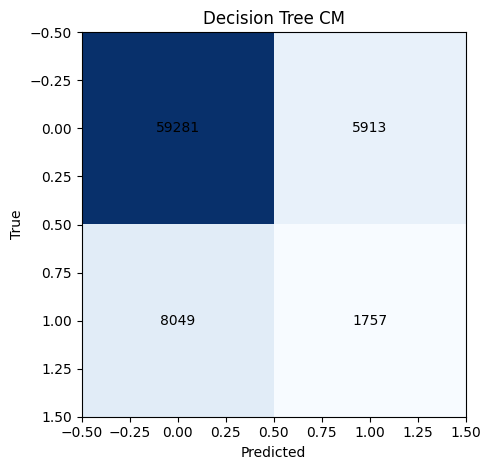

In [ ]:
dt_model, dt_cm = train_and_eval(
    DecisionTreeClassifier(max_depth=12,
                          #  class_weight="balanced",
                           random_state=RANDOM_STATE),
    "Decision Tree"
)
plot_cm(dt_cm, "Decision Tree CM")

imblearn not installed; running Random Forest without oversampling.

===== Random Forest === পল্ল  
Accuracy           : 0.84776
Balanced Accuracy  : 0.5598076406869142
Precision (positive class=1): 0.33697411003236244
Recall (Sensitivity): 0.169895982051805
Specificity        : 0.9497192993220235
F1 Score           : 0.22589830508474576
ROC-AUC            : 0.6776014823477541
Confusion Matrix:
 [[61916  3278]
 [ 8140  1666]]

Classification report:
               precision    recall  f1-score   support

           0      0.884     0.950     0.916     65194
           1      0.337     0.170     0.226      9806

    accuracy                          0.848     75000
   macro avg      0.610     0.560     0.571     75000
weighted avg      0.812     0.848     0.825     75000



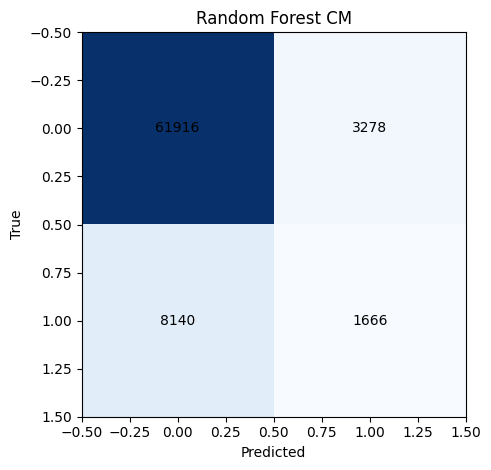

In [ ]:
rf_model, rf_cm = train_and_eval(
    RandomForestClassifier(
        n_estimators=50,
        max_depth=20,
        random_state=RANDOM_STATE,
        # class_weight="balanced",
        n_jobs=-1
    ),
    "Random Forest"
)
plot_cm(rf_cm, "Random Forest CM")

imblearn not installed; running MLP Classifier without oversampling.

===== MLP Classifier === পল্ল  
Accuracy           : 0.8621733333333333
Balanced Accuracy  : 0.5145117219013114
Precision (positive class=1): 0.30885529157667385
Recall (Sensitivity): 0.043748725270242705
Specificity        : 0.9852747185323802
F1 Score           : 0.07664135774899508
ROC-AUC            : 0.6484206950421202
Confusion Matrix:
 [[64234   960]
 [ 9377   429]]

Classification report:
               precision    recall  f1-score   support

           0      0.873     0.985     0.926     65194
           1      0.309     0.044     0.077      9806

    accuracy                          0.862     75000
   macro avg      0.591     0.515     0.501     75000
weighted avg      0.799     0.862     0.815     75000



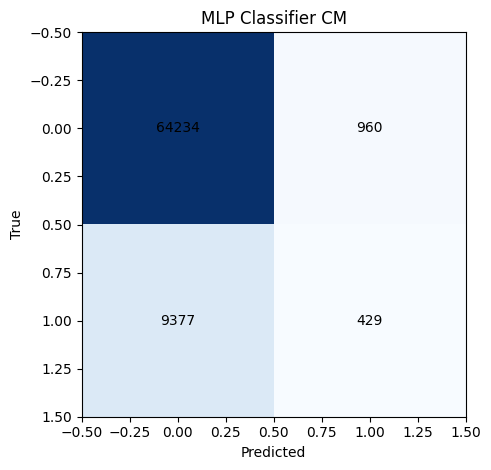

In [ ]:
mlp_model, mlp_cm = train_and_eval(
    MLPClassifier(
        hidden_layer_sizes=(100, 50),
        max_iter=500,
        random_state=RANDOM_STATE,
        early_stopping=True
    ),
    "MLP Classifier"
)
plot_cm(mlp_cm, "MLP Classifier CM")

In [20]:
metrics_df = pd.DataFrame(all_metrics)
metrics_df = metrics_df.set_index('model')
display(metrics_df.round(3))


,accuracy,balanced_accuracy,precision,recall,specificity,f1,roc_auc,tn,fp,fn,tp
model,,,,,,,,,,,
Logistic Regression,0.856,0.548,0.361,0.130,0.965,0.191,0.670,62944,2250,8536,1270
Decision Tree,0.814,0.544,0.229,0.179,0.909,0.201,0.605,59281,5913,8049,1757
Random Forest,0.848,0.560,0.337,0.170,0.950,0.226,0.678,61916,3278,8140,1666
MLP Classifier,0.862,0.515,0.309,0.044,0.985,0.077,0.648,64234,960,9377,429


# Task
Import `SMOTE` from `imblearn.over_sampling` and redefine the `train_and_eval` function to use `SMOTE` for oversampling instead of `RandomOverSampler`. Then, retrain and evaluate the Logistic Regression, Decision Tree, Random Forest, and MLP Classifier models using this new pipeline. Finally, aggregate the performance metrics into a DataFrame and display the results to summarize the impact of applying SMOTE.

## Import SMOTE and Update Training Function

### Subtask:
Import the SMOTE library and redefine the training function to use SMOTE for oversampling.


**Reasoning**:
Import SMOTE, initialize the metrics list, and redefine the training function to use SMOTE for oversampling as per the instructions.



In [ ]:
try:
    from imblearn.over_sampling import SMOTE
except ImportError:
    SMOTE = None
    print("SMOTE not installed.")

all_metrics_smote = []

def train_and_eval(model, model_name):
    # Ensure SMOTE and ImbPipeline are available
    if SMOTE is None or 'ImbPipeline' not in globals():
        print("SMOTE or ImbPipeline not available. Please check installations.")
        return None, None

    # Define pipeline steps with SMOTE
    steps = [
        ("preprocessor", preprocessor),
        ("oversample", SMOTE(random_state=RANDOM_STATE)),
        ("model", model)
    ]

    pipe = ImbPipeline(steps=steps)

    # Fit the pipeline
    pipe.fit(X_train, y_train)

    # Predictions
    preds = pipe.predict(X_val)

    try:
        proba = pipe.predict_proba(X_val)[:, 1]
    except AttributeError:
        proba = None

    # Metrics calculation
    acc = accuracy_score(y_val, preds)
    prec = precision_score(y_val, preds, zero_division=0)
    rec = recall_score(y_val, preds, zero_division=0)
    f1 = f1_score(y_val, preds, zero_division=0)
    bal_acc = balanced_accuracy_score(y_val, preds)

    cm = confusion_matrix(y_val, preds)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else np.nan

    if proba is not None:
        roc_auc = roc_auc_score(y_val, proba)
    else:
        roc_auc = np.nan

    # Display results
    print(f"\n===== {model_name} (SMOTE) === ")
    print("Accuracy           :", acc)
    print("Balanced Accuracy  :", bal_acc)
    print("Precision (positive class=1):", prec)
    print("Recall (Sensitivity):", rec)
    print("Specificity        :", specificity)
    print("F1 Score           :", f1)
    print("ROC-AUC            :", roc_auc)
    print("Confusion Matrix:\n", cm)
    print("\nClassification report:\n",
          classification_report(y_val, preds, digits=3))

    # Store metrics in the SMOTE specific list
    all_metrics_smote.append({
        "model": model_name,
        "accuracy": acc,
        "balanced_accuracy": bal_acc,
        "precision": prec,
        "recall": rec,
        "specificity": specificity,
        "f1": f1,
        "roc_auc": roc_auc,
        "tn": tn,
        "fp": fp,
        "fn": fn,
        "tp": tp,
    })

    return pipe, cm

print("SMOTE imported and 'train_and_eval' redefined to use SMOTE.")

SMOTE imported and 'train_and_eval' redefined to use SMOTE.


**Reasoning**:
Retrain the Logistic Regression, Decision Tree, Random Forest, and MLP models using the redefined `train_and_eval` function with SMOTE. Then, aggregate the gathered metrics into a DataFrame and display it to evaluate the performance.



In [ ]:
# Clear the list to ensure fresh results if cell is re-run
all_metrics_smote = []

# Retrain Logistic Regression with SMOTE
lr_model_smote, lr_cm_smote = train_and_eval(
    LogisticRegression(max_iter=1000, class_weight="balanced", random_state=RANDOM_STATE),
    "Logistic Regression"
)

# Retrain Decision Tree with SMOTE
dt_model_smote, dt_cm_smote = train_and_eval(
    DecisionTreeClassifier(max_depth=12, class_weight="balanced", random_state=RANDOM_STATE),
    "Decision Tree"
)

# Retrain Random Forest with SMOTE
rf_model_smote, rf_cm_smote = train_and_eval(
    RandomForestClassifier(
        n_estimators=50,
        max_depth=20,
        random_state=RANDOM_STATE,
        class_weight="balanced",
        n_jobs=-1
    ),
    "Random Forest"
)

# Retrain MLP Classifier with SMOTE
mlp_model_smote, mlp_cm_smote = train_and_eval(
    MLPClassifier(
        hidden_layer_sizes=(100, 50),
        max_iter=500,
        random_state=RANDOM_STATE,
        early_stopping=True
    ),
    "MLP Classifier"
)

# Aggregate metrics into a DataFrame
metrics_smote_df = pd.DataFrame(all_metrics_smote)
if not metrics_smote_df.empty:
    metrics_smote_df = metrics_smote_df.set_index('model')
    print("\nPerformance Metrics with SMOTE:")
    display(metrics_smote_df.round(3))
else:
    print("No metrics collected.")


===== Logistic Regression (SMOTE) === 
Accuracy           : 0.85608
Balanced Accuracy  : 0.5453160582409209
Precision (positive class=1): 0.35597667638483965
Recall (Sensitivity): 0.12451560269222925
Specificity        : 0.9661165137896125
F1 Score           : 0.18449682683590207
ROC-AUC            : 0.6661256820517881
Confusion Matrix:
 [[62985  2209]
 [ 8585  1221]]

Classification report:
               precision    recall  f1-score   support

           0      0.880     0.966     0.921     65194
           1      0.356     0.125     0.184      9806

    accuracy                          0.856     75000
   macro avg      0.618     0.545     0.553     75000
weighted avg      0.812     0.856     0.825     75000


===== Decision Tree (SMOTE) === 
Accuracy           : 0.85228
Balanced Accuracy  : 0.5438667104117014
Precision (positive class=1): 0.330221392371299
Recall (Sensitivity): 0.12624923516214562
Specificity        : 0.9614841856612572
F1 Score           : 0.18266322390261897
RO

,accuracy,balanced_accuracy,precision,recall,specificity,f1,roc_auc,tn,fp,fn,tp
model,,,,,,,,,,,
Logistic Regression,0.856,0.545,0.356,0.125,0.966,0.184,0.666,62985,2209,8585,1221
Decision Tree,0.852,0.544,0.330,0.126,0.961,0.183,0.605,62683,2511,8568,1238
Random Forest,0.846,0.564,0.337,0.183,0.946,0.237,0.669,61654,3540,8010,1796
MLP Classifier,0.834,0.523,0.216,0.101,0.945,0.138,0.592,61579,3615,8811,995
